In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from yahooquery import Ticker

In [1]:
ticker = Ticker(['^BVSP', 'ITSA4.SA', 'MGLU3.SA', 'VVAR3.SA', 'WEGE3.SA',
                'MDIA3.SA', 'LREN3.SA', 'ITUB3.SA', 'EGIE3.SA'])
df = ticker.history(period="max")

NameError: name 'Ticker' is not defined

## Metrics

### Daily returns

In [379]:
# Filter only 2020 data
start_date = '2020-01-01'
end_date = '2020-12-31' #'2020-12-31'

In [380]:
def get_data(df, ticker, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    data = df[df.symbol == ticker].copy()
    
    data = data[(data.date >= start_date) & (data.date <= end_date)].copy()
    data.set_index('date', inplace=True)
    
    return data

In [975]:
ibov = get_data(df, '^BVSP', start_date, end_date)

In [976]:
itsa = get_data(df, 'ITSA4.SA', start_date, end_date)

In [977]:
mglu = get_data(df, 'MGLU3.SA', start_date, end_date)

In [827]:
def calculate_n_day_return(df, col_name='adjclose', window=1):
    n_day_return = (df[col_name]/df[col_name].shift(window)) - 1
    n_day_return.fillna(0, inplace=True)
    
    return n_day_return

In [814]:
d_return_ibov = calculate_n_day_return(ibov)
d_return_itsa = calculate_n_day_return(itsa)
d_return_mglu = calculate_n_day_return(mglu)

<AxesSubplot:xlabel='date'>

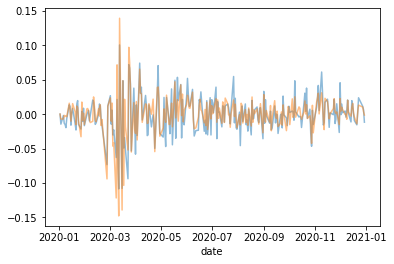

In [387]:
d_return_itsa.plot(alpha=0.5)
d_return_ibov.plot(alpha=0.5)

In [388]:
#pd.concat([d_return_itsa, d_return_ibov], axis=1)

### CMPM

In [389]:
# def calculate_capm(d_return_a, d_return_b, window, ):
    
# #     if plot:
# #         compare_both = pd.DataFrame({label_a: d_return_a, label_b: d_return_b})
# #         compare_both.plot.scatter(x=label_b, y=label_a)
    
#     beta, alpha = np.polyfit(d_return_b, d_return_a, 1)
    
#     return beta, alpha

In [1008]:
def calculate_capm(df_a, df_b, window, col_name_a='adjclose', col_name_b='adjclose'):
    arr_a = df_a.copy()
    arr_b = df_b.copy()

    if len(arr_a) != len(arr_b):
        raise ValueError('Length input arrays are different.')

    day_return_a = calculate_n_day_return(arr_a, col_name_a, 1)
    day_return_b = calculate_n_day_return(arr_b, col_name_b, 1)

    result = []

    # Slide the windown between the entire array
    # Last point was skipped because is not possible fit a line
    # only with 1 point
    for iter in range(0, len(arr_a) - 1):
        if iter == 0:
            arr_w_a = day_return_a[-window:]
            arr_w_b = day_return_b[-window:]
        else:
            arr_w_a = day_return_a[-(window + iter):-iter]
            arr_w_b = day_return_b[-(window + iter):-iter]

        date = arr_w_a.tail(1).index[0]
        beta, alpha = np.polyfit(arr_w_a, arr_w_b, 1)
        result.append((date, beta, alpha))
        result_df = pd.DataFrame(result, columns=['date', 'beta', 'alpha'])
        result_df.set_index('date', inplace=True)
        result_df.sort_index(inplace=True)
        
    return result_df

In [1016]:
beta = calculate_capm(itsa, ibov, 100).beta

In [1017]:
beta

date
2020-01-03    0.499074
2020-01-06    0.333361
2020-01-07    0.141880
2020-01-08    0.098579
2020-01-09    0.029747
                ...   
2020-12-22    0.617163
2020-12-23    0.619052
2020-12-28    0.615203
2020-12-29    0.615230
2020-12-30    0.629752
Name: beta, Length: 246, dtype: float64

### Momentum

In [391]:
def calculate_momentum(df, col_name, n):
    momentum = (df[col_name]/df[col_name].shift(n)) - 1
    momentum.fillna(0, inplace=True)
    
    return momentum

In [392]:
calculate_momentum(ibov, 'adjclose', 5)

date
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-06    0.000000
2020-01-07    0.000000
2020-01-08    0.000000
                ...   
2020-12-22    0.001739
2020-12-23   -0.000763
2020-12-28    0.007566
2020-12-29    0.015262
2020-12-30    0.028358
Name: adjclose, Length: 247, dtype: float64

### Simple Moving Average (SMA)

In [408]:
def calculate_sma(df, col_name, window):
    
    sma = df[col_name].rolling(window).mean()
    
    result = (df[col_name]/sma) - 1
        
    result.fillna(0, inplace=True)
    
    return result

In [409]:
calculate_sma(itsa, 'adjclose', 20)

date
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-06    0.000000
2020-01-07    0.000000
2020-01-08    0.000000
                ...   
2020-12-22    0.021199
2020-12-23    0.040745
2020-12-28    0.046715
2020-12-29    0.047736
2020-12-30    0.029638
Name: adjclose, Length: 247, dtype: float64

<AxesSubplot:xlabel='date'>

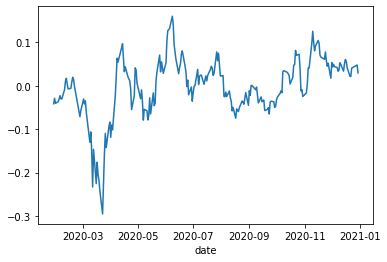

In [395]:
sma.plot()

### Volatility

In [397]:
def calculate_volatility(df, col_name, window):
    
    vol = df[col_name].rolling(window).std()
    vol.fillna(0, inplace=True)
    
    return vol

In [414]:
calculate_volatility(itsa, 'adjclose', 50)

date
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-06    0.000000
2020-01-07    0.000000
2020-01-08    0.000000
                ...   
2020-12-22    0.869623
2020-12-23    0.874886
2020-12-28    0.880204
2020-12-29    0.883688
2020-12-30    0.878541
Name: adjclose, Length: 247, dtype: float64

### Exponencial mean average (EMA)

In [399]:
itsa.iat[0, 6] = 0

In [645]:
def calculate_ema(df, col_name, window):
    
    arr = df[col_name].copy()
    
    result = []

    # Calculate last line
    result.append(arr[-window:].ewm(span=window, adjust=False).mean().tail(1))

    # Slide the windown between the entire array
    for iter in range(1, len(arr)):
        result.append(arr[-(window + iter):-iter].ewm(span=5).mean().tail(1))

    ema = pd.concat(result).sort_index()
    ema_pct = (arr/ema) - 1
    ema_pct.fillna(0, inplace=True)
    
    return ema_pct

<AxesSubplot:xlabel='date'>

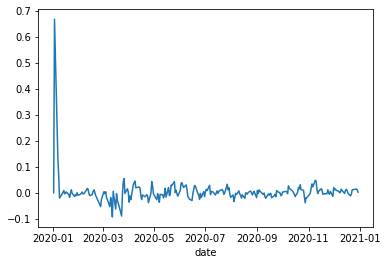

In [648]:
calculate_ema(itsa, 'adjclose', 5).plot()

## PREP

In [1122]:
sma = calculate_sma(itsa, 'adjclose', 60)

In [1123]:
# momentum = calculate_momentum(itsa, 'adjclose', 1)

In [1124]:
momentum_df = pd.DataFrame(momentum, columns=['adjclose'])

In [1125]:
sma_momentum = calculate_sma(momentum_df, 'adjclose', 60)

In [1126]:
sma_ibov = calculate_sma(ibov, 'adjclose', 40)

In [1127]:
volatility_ibov = calculate_volatility(ibov, 'adjclose', 40)

In [1128]:
volatility = calculate_volatility(itsa, 'adjclose', 40)

In [1129]:
ema = calculate_ema(itsa, 'adjclose', 60)

In [1130]:
beta = calculate_capm(itsa, ibov, 40).beta

In [1131]:
daily_return = calculate_n_day_return(itsa)

In [1132]:
def calculate_cum_return(df, col_name, n_days):
    cum_return = calculate_n_day_return(df, col_name=col_name, window=n_days)
    cum_return = cum_return.shift(-n_days)
    
    
    return cum_return

In [1133]:
n_days = 30

In [1134]:
target = calculate_cum_return(itsa, 'adjclose', n_days)

In [1135]:
modeling_df = pd.concat([sma,
                         sma_momentum,
                         sma_ibov,
                         volatility_ibov,
                         volatility,
                         ema,
                         beta,
                         daily_return,
                         target], axis=1)

In [1136]:
modeling_df = modeling_df.iloc[:-n_days]

In [1137]:
modeling_df = modeling_df.iloc[99:]

In [1138]:
modeling_df.reset_index(inplace=True)

In [1139]:
modeling_df.columns = ['date',
                       'sma',
                       'sma_momentum',
                       'sma_ibov',
                       'volatility_ibov',
                       'volatility',
                       'ema',
                       'beta',
                       'daily_return',
                       'target']

In [1140]:
modeling_df.date = modeling_df.date.astype('str')

### Train test split

In [1141]:
train = modeling_df[modeling_df.date < '2020-10-01'].copy()

train.drop('date', axis=1, inplace=True)

X_train = train.drop('target', axis=1)
y_train = train.target.values

test = modeling_df[modeling_df.date >= '2020-10-01'].copy()

test.drop('date', axis=1, inplace=True)

X_test = test.drop('target', axis=1)
y_test = test.target.values

## Modeling

In [1147]:
from sklearn.linear_model import LinearRegression

In [1148]:
lreg = LinearRegression(normalize=True)

In [1149]:
lreg.fit(X_train, y_train)

LinearRegression(normalize=True)

In [1150]:
from sklearn.ensemble import RandomForestRegressor

In [1151]:
rfr = RandomForestRegressor(random_state=0)

In [1152]:
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

## Evaluate

In [1153]:
y_pred = lreg.predict(X_test)

In [1154]:
y_pred = rfr.predict(X_test)

In [1155]:
### fazer a conta se pelo menos acerto a direcao, cair, subir ou ficar na mesma (intervalo de 0.5pct)

In [1156]:
pd.concat([pd.Series(y_test, name='true'), pd.Series(y_pred, name='pred')], axis=1).round(3)

,true,pred
0,0.222,0.138
1,0.223,0.165
2,0.194,0.126
3,0.194,0.087
4,0.203,0.098
5,0.173,0.043
6,0.153,0.055
7,0.149,0.071
8,0.170,0.068
9,0.144,0.046


In [1157]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred)